### 공공 데이터 사용하기 (Q6.2)
- 05장_2_openapi_tour.py 프로그램을 수행하여라.
- 국가는 중국로 설정한다.
- 기간은 코로나 기간이 포함되도록 5년 정도를 조사한다. 
- 결과를 보고 ‘입국자수'에 대한 막대그래프를 그려본다.

In [3]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

ServiceKey="edSnzhmFwkaoSFwGnzfI%2FVoqtQcqDM67Uzv%2BQmbp7OkjHCY6j%2B9Pq%2BriPr7jQXagfQA0GRllEZL%2BhWBQSljPIw%3D%3D"

# 생성한 url 받아서 데이터 가져오기
def getRequestUrl(url):    
    req = urllib.request.Request(url)    
    try: 
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print ("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None
    
# url 생성
def getTourismStatsItem(yyyymm, national_code, ed_cd):    
    service_url = "http://openapi.tour.go.kr/openapi/service/EdrcntTourismStatsService/getEdrcntTourismStatsList"
    
    parameters = "?_type=json&serviceKey=" + ServiceKey   #인증키
    parameters += "&YM=" + yyyymm
    parameters += "&NAT_CD=" + national_code
    parameters += "&ED_CD=" + ed_cd

    url = service_url + parameters
    
    retData = getRequestUrl(url)   #[CODE 1]
    
    if (retData == None):
        return None
    else:
         return json.loads(retData)
        
# 시작 년도부터 끝 년도까지의 데이터 가져오기
def getTourismStatsService(nat_cd, ed_cd, nStartYear, nEndYear):
    jsonResult = []
    result = []
    dataEND = "{0}{1:0>2}".format(str(nEndYear+1), str(12)) #데이터 끝 초기화
    isDataEnd = 0 #데이터 끝 확인용 flag 초기화
    
    for year in range(nStartYear, nEndYear+1):        
        for month in range(1, 13):
            if(isDataEnd == 1): break #데이터 끝 flag 설정되어있으면 작업 중지.
            yyyymm = "{0}{1:0>2}".format(str(year), str(month))            
            jsonData = getTourismStatsItem(yyyymm, nat_cd, ed_cd) #[CODE 2]        
            if (jsonData['response']['header']['resultMsg'] == 'OK'):               
                # 입력된 범위까지 수집하지 않았지만, 더이상 제공되는 데이터가 없는 마지막 항목인 경우 -------------------
                if jsonData['response']['body']['items'] == '': 
                    isDataEnd = 1 #데이터 끝 flag 설정
                    dataEND = "{0}{1:0>2}".format(str(year), str(month-1))
                    print("데이터 없음.... \n 제공되는 통계 데이터는 %s년 %s월까지입니다."                          
                          %(str(year), str(month-1)))                    
                    break                
                #jsonData를 출력하여 확인......................................................
                print (json.dumps(jsonData, indent=4, sort_keys=True, ensure_ascii=False))          
                natName = jsonData['response']['body']['items']['item']['natKorNm']
                natName = natName.replace(' ', '')
                num = jsonData['response']['body']['items']['item']['num']
                ed = jsonData['response']['body']['items']['item']['ed']
                print('[ %s_%s : %s ]' %(natName, yyyymm, num))
                print('----------------------------------------------------------------------')                
                jsonResult.append({'nat_name': natName, 'nat_cd': nat_cd,
                                 'yyyymm': yyyymm, 'visit_cnt': num})
                result.append([natName, nat_cd, yyyymm, num])
            
    return (jsonResult, result, natName, ed, dataEND)

# 크롤링하기
def main():
    jsonResult = []
    result = []

    print("<< 국내 입국한 외국인의 통계 데이터를 수집합니다. >>")
    nat_cd = input('국가 코드를 입력하세요(중국: 112 / 일본: 130 / 미국: 275) : ')
    nStartYear =int(input('데이터를 몇 년부터 수집할까요? : '))
    nEndYear = int(input('데이터를 몇 년까지 수집할까요? : '))
    ed_cd = "E" #E : 방한외래관광객, D : 해외 출국
    
    jsonResult, result, natName, ed, dataEND = getTourismStatsService(nat_cd, ed_cd, nStartYear, nEndYear) #[CODE 3]
 
    #파일저장 1 : json 파일       
    with open('./%s_%s_%d_%s.json' % (natName, ed, nStartYear, dataEND), 'w', encoding='utf8') as outfile:
        jsonFile  = json.dumps(jsonResult, indent=4, sort_keys=True, ensure_ascii=False)
        outfile.write(jsonFile)
    #파일저장 2 : csv 파일   
    columns = ["입국자국가", "국가코드", "입국연월", "입국자 수"]
    result_df = pd.DataFrame(result, columns = columns)
    result_df.to_csv('./%s_%s_%d_%s.csv' % (natName, ed, nStartYear, dataEND), index=False, encoding='cp949')
    
if __name__ == '__main__':
    main()
    
    
# 국가는 중국
# 기간은 코로나 기간이 포함되도록 5년 정도
# 2018, 2019, 2020, 2021, 2022

<< 국내 입국한 외국인의 통계 데이터를 수집합니다. >>
국가 코드를 입력하세요(중국: 112 / 일본: 130 / 미국: 275) : 112
데이터를 몇 년부터 수집할까요? : 2018
데이터를 몇 년까지 수집할까요? : 2022
[2023-04-12 16:11:31.099878] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 305127,
                    "rnum": 1,
                    "ym": 201801
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_201801 : 305127 ]
----------------------------------------------------------------------
[2023-04-12 16:11:31.157386] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관

[2023-04-12 16:11:31.730596] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 392814,
                    "rnum": 1,
                    "ym": 201901
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_201901 : 392814 ]
----------------------------------------------------------------------
[2023-04-12 16:11:31.781824] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                   

[2023-04-12 16:11:32.439545] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 16595,
                    "rnum": 1,
                    "ym": 202003
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_202003 : 16595 ]
----------------------------------------------------------------------
[2023-04-12 16:11:32.487629] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "

[2023-04-12 16:11:33.095463] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 16830,
                    "rnum": 1,
                    "ym": 202104
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_202104 : 16830 ]
----------------------------------------------------------------------
[2023-04-12 16:11:33.147524] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "

[2023-04-12 16:11:33.719608] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 10230,
                    "rnum": 1,
                    "ym": 202204
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_202204 : 10230 ]
----------------------------------------------------------------------
[2023-04-12 16:11:33.776333] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "

['201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112', '202201', '202202', '202203', '202204', '202205', '202206', '202207', '202208', '202209', '202210', '202211', '202212']
[305127, 345341, 403413, 366604, 370222, 379891, 410337, 478140, 434595, 475307, 404256, 416279, 392814, 453379, 487623, 493250, 500413, 475007, 519132, 578112, 541350, 567695, 505369, 508877, 481681, 104086, 16595, 3935, 5124, 5051, 9738, 16275, 15307, 11477, 9174, 7987, 7346, 11982, 18980, 16830, 14221, 12942, 13469, 17103, 19144, 14035, 12472, 11691, 9489, 16752, 14726, 10230, 11253, 12741, 17

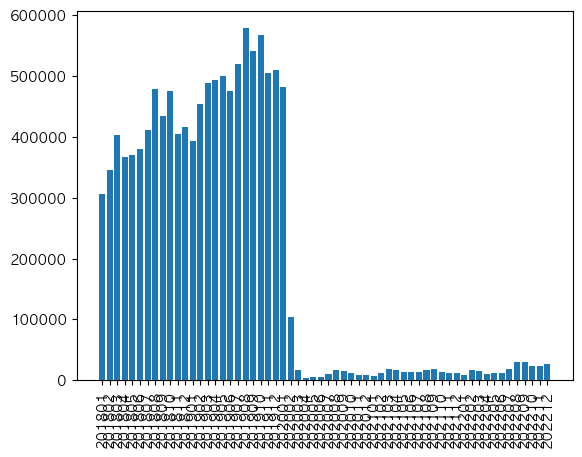

In [20]:
# ‘입국자수'에 대한 막대그래프
import csv
import matplotlib.pyplot as plt
f = open('/Users/min0/Documents/Documents/school/4-1/빅데이터/jupyter/hw/중국_방한외래관광객_2018_202312.csv', 'r', encoding='cp949')
data = csv.reader(f)
next(data)


# 데이터는 다음과 같음
#['입국자국가', '국가코드', '입국연월', '입국자 수']
#['중국', '112', '201801', '305127']
#['중국', '112', '201802', '345341']
#['중국', '112', '201803', '403413']
#['중국', '112', '201804', '366604']

yyyymm = [''] * (12 * 5)
persons = [0] * (12 * 5)
index = 0
for row in data :
    yyyymm[index] = row[2]
    persons[index] = int(row[3]) # 정수 처리
    index = index + 1
    
#plt.figure(dpi = 300)
plt.rcParams['font.family'] = 'AppleGothic'
plt.bar(yyyymm, persons)
plt.xticks(rotation=90) 
plt.show()
f.close()

